# Machine Learning Lab Guide — Repro Notebook

This notebook follows the structure and steps described in the provided lab guide PDF, with two main parts:
1. **Flower Category Analysis (Iris)**
2. **Emotion Recognition of Customer Evaluations in the Retail Industry**

> **Note**: Where the original retail reviews dataset is unavailable, a small synthetic sample is used so the pipeline runs end-to-end. If you have the original dataset, update the file path in the indicated cell and re-run those cells.

## 1. Flower Category Analysis
### 1.1 Introduction
This experiment uses the built-in **Iris** dataset from scikit-learn. The task is a simple multi-class classification to illustrate sklearn workflows (data splitting, modeling, evaluation).

### 1.2 Experiment Code
#### 1.2.1 Importing Related Libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

%matplotlib inline


#### 1.2.2 Importing a Dataset

In [18]:
# Load the Iris dataset (built into scikit-learn)
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print('Features:', feature_names)
print('Targets:', target_names)
print('Total samples:', X.shape[0])
print('Total features:', X.shape[1])

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets: ['setosa' 'versicolor' 'virginica']
Total samples: 150
Total features: 4


#### 1.2.3 Splitting the Dataset

In [19]:
# Split into train/test
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=12, stratify=y, shuffle=True
)
print('Data size before splitting: X:', X.shape, ' y:', y.shape)
print('Data size after splitting:')
print('  X_tr:', X_tr.shape, ' y_tr:', y_tr.shape)
print('  X_te:', X_te.shape, ' y_te:', y_te.shape)

Data size before splitting: X: (150, 4)  y: (150,)
Data size after splitting:
  X_tr: (112, 4)  y_tr: (112,)
  X_te: (38, 4)  y_te: (38,)


#### 1.2.4 Performing Modeling
##### 1.2.4.1 Logistic Regression

In [20]:
# Logistic Regression (multiclass OvR by default in scikit-learn)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_tr, y_tr)
pred_lr = log_reg.predict(X_te)
acc_lr = accuracy_score(y_te, pred_lr)
print('Logistic Regression accuracy:', round(acc_lr, 4))

Logistic Regression accuracy: 0.9211


##### 1.2.4.2 SVM

In [21]:
# Support Vector Machine (SVC), default OvR for multi-class
svc = svm.SVC()
svc.fit(X_tr, y_tr)
pred_svc = svc.predict(X_te)
acc_svc = accuracy_score(y_te, pred_svc)
print('SVM accuracy:', round(acc_svc, 4))

SVM accuracy: 0.8947


##### 1.2.4.3 Decision Tree

In [22]:
dt = DecisionTreeClassifier(random_state=12)
dt.fit(X_tr, y_tr)
pred_dt = dt.predict(X_te)
acc_dt = accuracy_score(y_te, pred_dt)
print('Decision Tree accuracy:', round(acc_dt, 4))

Decision Tree accuracy: 0.9474


##### 1.2.4.4 K-Nearest Neighbors Algorithm

Best k: 14 with accuracy: 0.9737


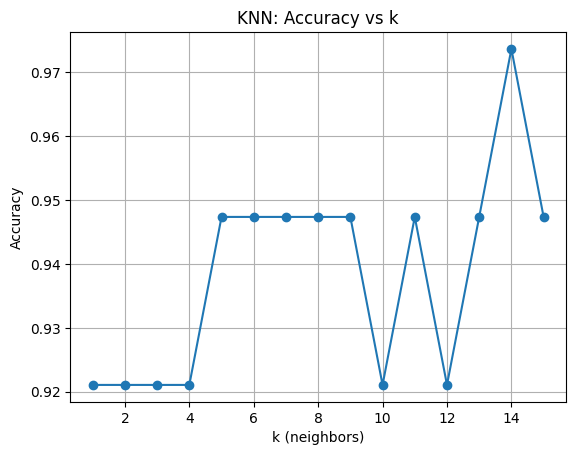

In [23]:
k_values = list(range(1, 16))
accs = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr, y_tr)
    pred_knn = knn.predict(X_te)
    accs.append(accuracy_score(y_te, pred_knn))

best_k = k_values[int(np.argmax(accs))]
best_acc = max(accs)
print('Best k:', best_k, 'with accuracy:', round(best_acc, 4))

# Plot k vs accuracy (single plot, no color specification)
plt.figure()
plt.plot(k_values, accs, marker='o')
plt.xlabel('k (neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN: Accuracy vs k')
plt.grid(True)
plt.show()

#### 1.2.5 Effect After Data Preprocessing

In [24]:
# Standardize features and re-train SVM
scaler = StandardScaler()
X_tr_std = scaler.fit_transform(X_tr)
X_te_std = scaler.transform(X_te)

svc_std = svm.SVC()
svc_std.fit(X_tr_std, y_tr)
pred_svc_std = svc_std.predict(X_te_std)
acc_svc_std = accuracy_score(y_te, pred_svc_std)
print('SVM accuracy after standardization:', round(acc_svc_std, 4))

# Show standardized training data mean ~0 and std ~1
print('Standardized train mean (approx):', np.round(X_tr_std.mean(axis=0), 4))
print('Standardized train std (approx):', np.round(X_tr_std.std(axis=0), 4))

SVM accuracy after standardization: 0.9211
Standardized train mean (approx): [-0. -0.  0.  0.]
Standardized train std (approx): [1. 1. 1. 1.]


---

## 2. Emotion Recognition of Customer Evaluations in the Retail Industry
### 2.1 Introduction & Objectives
We demonstrate an NLP classification pipeline that labels reviews as positive or negative based on ratings. This section mirrors the steps in the guide: data reading, visualization, processing, model training (MultinomialNB, BernoulliNB, Logistic Regression), and verification.

### 2.2 Procedure

#### 2.2.1 Data Management
Expected columns of interest:
- `Id`
- `reviews.rating`
- `reviews.text`
- `reviews.title`
- `reviews.username`

If you have the original CSV, place it at `/mnt/data/retail_reviews.csv` and set `USE_SYNTHETIC=False` in the next cell.

#### 2.2.2 Data Reading

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
import re
import string

USE_SYNTHETIC = True  # Set to False if you provide a real file at /mnt/data/retail_reviews.csv
FILE_PATH = '/mnt/data/retail_reviews.csv'

if USE_SYNTHETIC:
    # Build a small synthetic dataset mimicking the expected columns
    rng = np.random.default_rng(42)
    n = 500
    ratings = rng.integers(low=1, high=6, size=n)
    texts = []
    titles = []
    for r in ratings:
        if r >= 4:
            t = 'Great product excellent quality works perfectly and highly recommended'
            title = 'Excellent'
        elif r == 3:
            t = 'Average item okay performance acceptable but could be better'
            title = 'Average'
        else:
            t = 'Terrible experience poor quality stopped working not recommended'
            title = 'Bad'
        texts.append(t)
        titles.append(title)
    df_raw = pd.DataFrame({
        'Id': np.arange(1, n+1),
        'reviews.rating': ratings,
        'reviews.text': texts,
        'reviews.title': titles,
        'reviews.username': [f'user_{i}' for i in range(n)]
    })
else:
    df_raw = pd.read_csv(FILE_PATH)

print('First 5 rows:')
display(df_raw.head())
print('\nColumns:', list(df_raw.columns))
print('\nShape:', df_raw.shape)

First 5 rows:


,Id,reviews.rating,reviews.text,reviews.title,reviews.username
0,1,1,Terrible experience poor quality stopped worki...,Bad,user_0
1,2,4,Great product excellent quality works perfectl...,Excellent,user_1
2,3,4,Great product excellent quality works perfectl...,Excellent,user_2
3,4,3,Average item okay performance acceptable but c...,Average,user_3
4,5,3,Average item okay performance acceptable but c...,Average,user_4



Columns: ['Id', 'reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username']

Shape: (500, 5)


Missing values by column:
 reviews.rating      0
reviews.text        0
reviews.title       0
reviews.username    0
dtype: int64


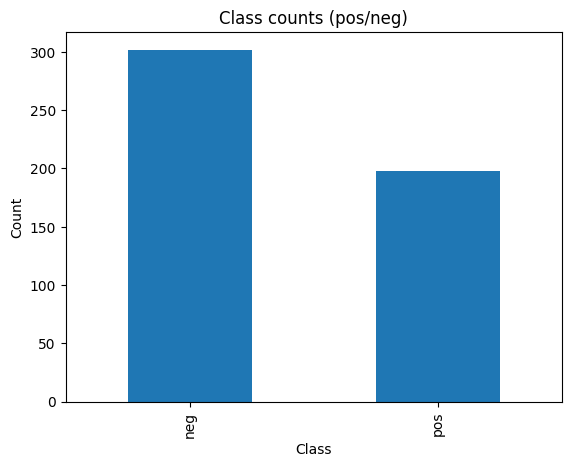

In [26]:
# Retain only the needed columns
cols = ['reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username']
df = df_raw[cols].copy()

# Inspect missing values
missing = df.isna().sum()
print('Missing values by column:\n', missing)

# Drop rows with missing reviews.rating (as per guide)
df_non_missing = df.dropna(subset=['reviews.rating']).copy()

# Define sentiment label: rating >= 4 => pos, else neg; rename column to 'senti'
df_non_missing['senti'] = np.where(df_non_missing['reviews.rating'] >= 4, 'pos', 'neg')

# Visualize class balance
counts = df_non_missing['senti'].value_counts().sort_index()
plt.figure()
counts.plot(kind='bar')
plt.title('Class counts (pos/neg)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#### 2.2.3 Data Processing

In [27]:
def cleanup(text: str) -> str:
    if not isinstance(text, str):
        return ''
    # Keep only letters, convert to lowercase, and remove extra whitespace
    text = re.sub(r'[^A-Za-z]+', ' ', text)
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_non_missing['Summary_Clean'] = df_non_missing['reviews.text'].apply(cleanup)
df_non_missing[['Summary_Clean', 'senti']].head()

,Summary_Clean,senti
0,terrible experience poor quality stopped worki...,neg
1,great product excellent quality works perfectl...,pos
2,great product excellent quality works perfectl...,pos
3,average item okay performance acceptable but c...,neg
4,average item okay performance acceptable but c...,neg


In [28]:
# Construct the split DataFrame with only Summary_Clean and senti
split = df_non_missing[['Summary_Clean', 'senti']].copy()
print('Split shape:', split.shape)

# 80% sample for train using sample(); remaining for test using drop()
train = split.sample(frac=0.8, random_state=42)
test = split.drop(train.index)
print('Train shape:', train.shape, ' Test shape:', test.shape)

Split shape: (500, 2)
Train shape: (400, 2)  Test shape: (100, 2)


#### 2.2.4 Model Training

In [29]:
# Vectorization (CountVectorizer) + TF-IDF (TfidfTransformer)
cv = CountVectorizer()
tfidf = TfidfTransformer()

# Fit on training text
X_train_counts = cv.fit_transform(train['Summary_Clean'])
X_train_tfidf = tfidf.fit_transform(X_train_counts)

# Transform test text
X_test_counts = cv.transform(test['Summary_Clean'])
X_test_tfidf = tfidf.transform(X_test_counts)

# Encode labels to binary 0/1 (neg=0, pos=1)
y_train = (train['senti'] == 'pos').astype(int).values
y_test = (test['senti'] == 'pos').astype(int).values

# Train models: MultinomialNB, BernoulliNB, Logistic Regression
models = {
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf if name != 'BernoulliNB' else (X_train_counts>0).astype(int), y_train)
    X_eval = X_test_tfidf if name != 'BernoulliNB' else (X_test_counts>0).astype(int)
    y_pred = model.predict(X_eval)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f'{name} accuracy: {acc:.4f}')

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print('\nBest model:', best_model_name, 'with accuracy:', round(results[best_model_name], 4))

MultinomialNB accuracy: 1.0000
BernoulliNB accuracy: 1.0000
LogisticRegression accuracy: 1.0000

Best model: MultinomialNB with accuracy: 1.0


In [30]:
# Verification: show probabilities for a few test samples using the best model if supported
def predict_proba_safe(model, X):
    if hasattr(model, 'predict_proba'):
        return model.predict_proba(X)
    elif hasattr(model, 'decision_function'):
        # Map decision function through sigmoid as a rough probability proxy
        import numpy as _np
        z = model.decision_function(X)
        # Handle binary case only
        if z.ndim == 1:
            probs_pos = 1.0 / (1.0 + _np.exp(-z))
            return _np.vstack([1 - probs_pos, probs_pos]).T
        else:
            # Softmax for multi-class (not needed here)
            e = _np.exp(z - z.max(axis=1, keepdims=True))
            return e / e.sum(axis=1, keepdims=True)
    else:
        return None

X_eval_best = X_test_tfidf if best_model_name != 'BernoulliNB' else (X_test_counts>0).astype(int)
probs = predict_proba_safe(best_model, X_eval_best)
if probs is not None:
    for i in range(min(5, X_eval_best.shape[0])):
        print(f'Sample {i}: P(neg)={probs[i,0]:.3f}, P(pos)={probs[i,1]:.3f}')
else:
    print('Best model does not provide probability outputs.')

Sample 0: P(neg)=0.000, P(pos)=1.000
Sample 1: P(neg)=0.000, P(pos)=1.000
Sample 2: P(neg)=1.000, P(pos)=0.000
Sample 3: P(neg)=1.000, P(pos)=0.000
Sample 4: P(neg)=0.000, P(pos)=1.000


##### Optional: Word Cloud (best-effort)

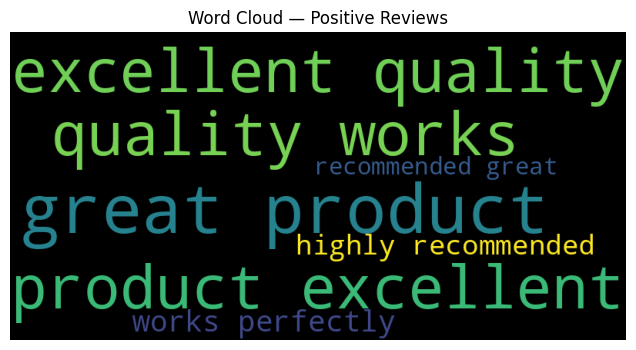

In [ ]:
try:
    from wordcloud import WordCloud
    # Build a word cloud 
    pos_text = ' '.join(train.loc[train['senti']=='pos', 'Summary_Clean'].tolist())
    wc = WordCloud(width=800, height=400)
    img = wc.generate(pos_text)
    plt.figure(figsize=(8,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Word Cloud — Positive Reviews')
    plt.show()
except Exception as e:
    print('WordCloud unavailable or failed to render:', e)

In [32]:
from datetime import datetime
print('Notebook generated at:', datetime.now())

Notebook generated at: 2025-08-20 12:05:52.004518
